In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [5]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [6]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        return np.aye(Q[0].shape[0])[np.argmax(Q[observation])]
    return policy_fn

In [9]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for t in range(num_episodes):
        episode = []
        state = env.reset()
        for t in range(100):
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        s_a_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in s_a_in_episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] for x in episode[first_occurence_idx:]])
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
        
    return Q, target_policy

In [10]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

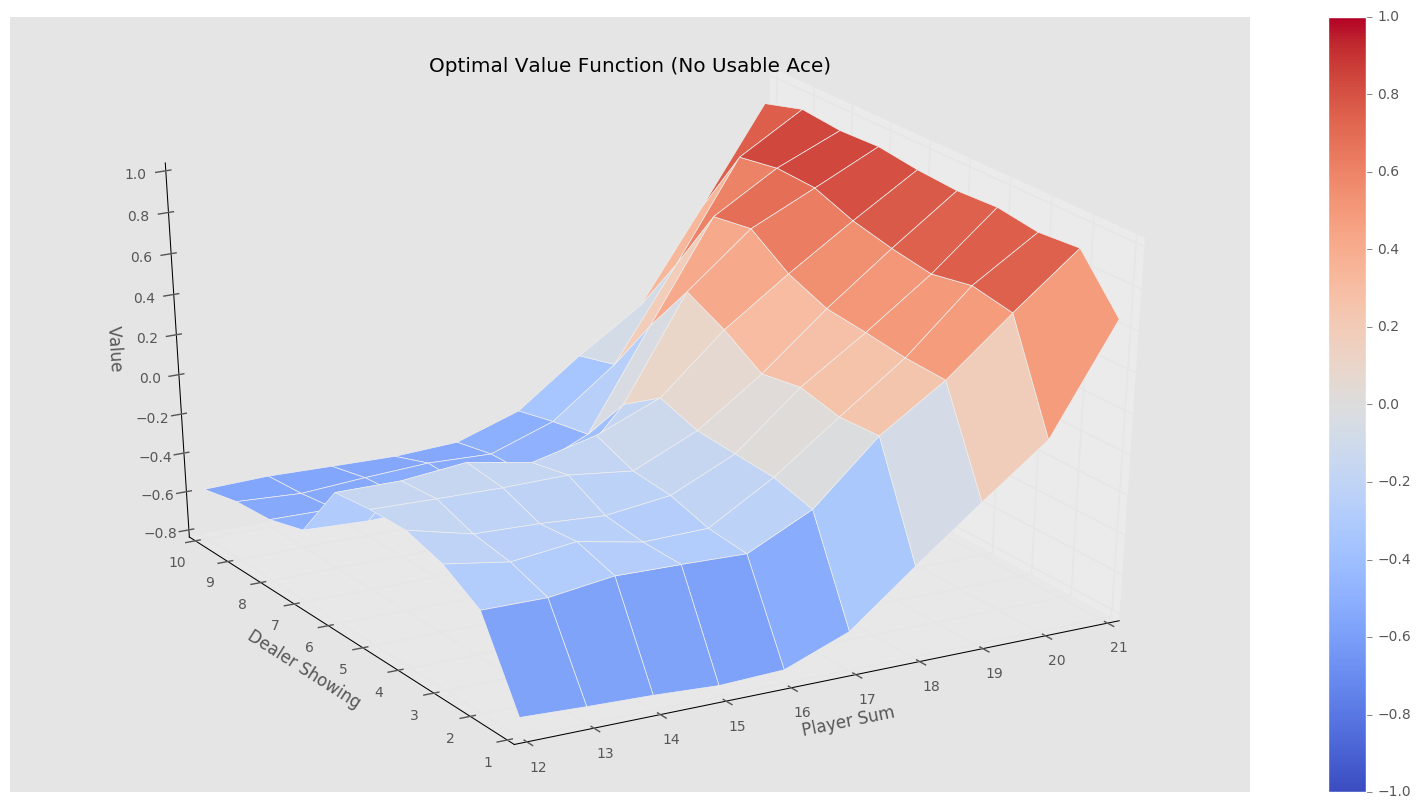

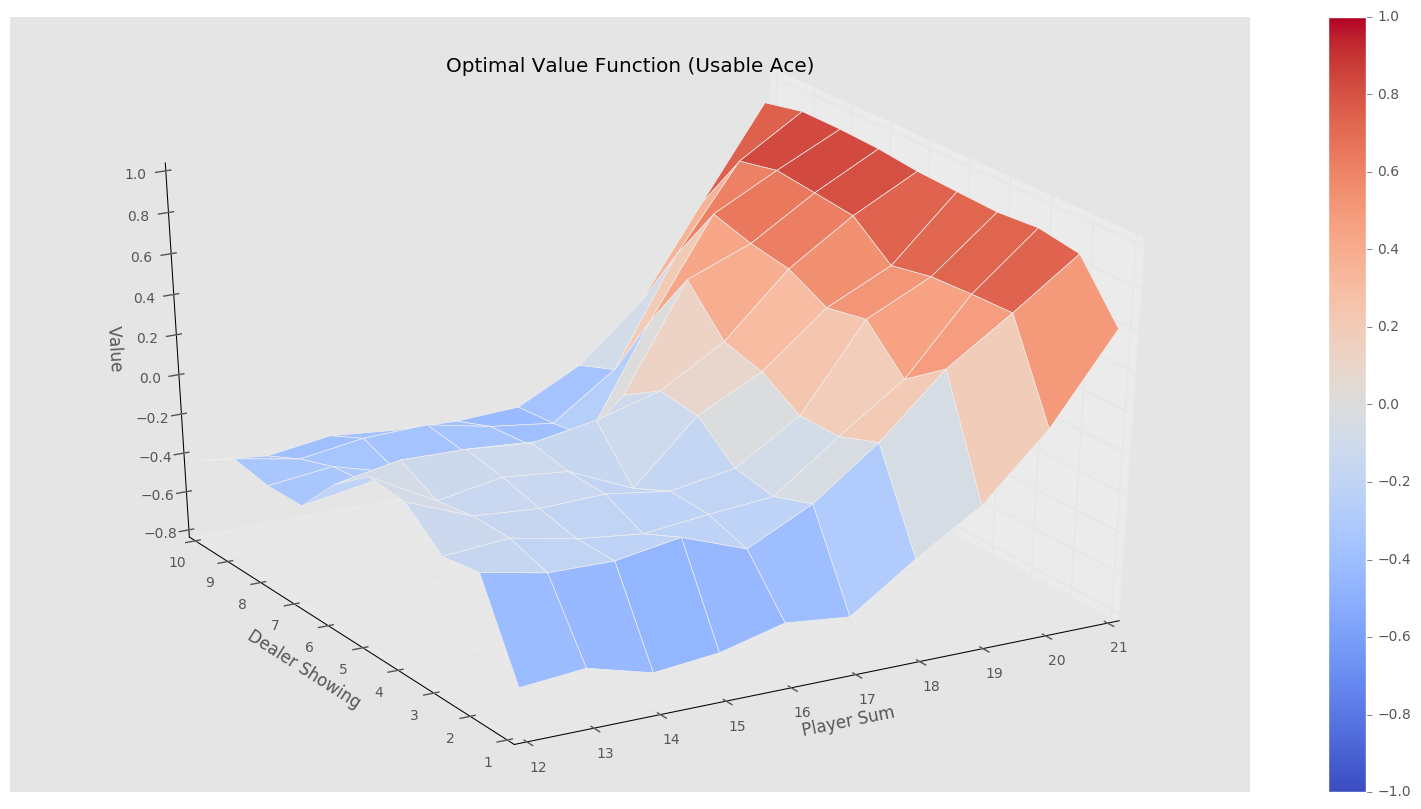

In [11]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")